In [1]:
import matplotlib # Importing matplotlib for it working on remote server
import matplotlib.pyplot as plt
import matplotlib.colors as color
%matplotlib inline

import numpy as np

import os, sys
home_dir = os.getcwd()

import torch

# because train
import random
random.seed(121)
torch.manual_seed(121)
torch.cuda.manual_seed(121)
torch.backends.cudnn.deterministic = True

import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms

import itertools, time

import simple_flint as flint
import tweak_image as tweak

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
train_shuffle = True
test_shuffle = True
train_epoch_info = []
test_epoch_info = []

criterion = nn.CrossEntropyLoss()
criterion2 = nn.L1Loss()

dataset = "cifar10"

In [3]:
print(torch.cuda.is_available())
print(device)

True
cuda


In [4]:
n_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
N_EPOCH = 25
norm_mean = (0.5,0.5,0.5) #(0.4914, 0.4822, 0.4465)
norm_std = (0.5,0.5,0.5) #(0.247, 0.243, 0.261)    
train_loader = torch.utils.data.DataLoader( datasets.CIFAR10(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.RandomCrop(32, padding=2), transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ])), batch_size=64, shuffle=train_shuffle, num_workers=32)
test_loader = torch.utils.data.DataLoader( datasets.CIFAR10(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ])), batch_size=32, shuffle=test_shuffle, num_workers=20) #batch_size 32
train_data = datasets.CIFAR10(home_dir + '/datasets', train=True, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ]))
test_data = datasets.CIFAR10(home_dir + '/datasets', train=False, download=True, transform=transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ]))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
latent_size = 36
f = flint.MyResNet(version='34', bn=False, n_classes=10, in_maps=3).to(device)
g = flint.attr_RN18_multi(out_size=latent_size).to(device)
d = flint.decode_CIFAR(in_size=latent_size).to(device)
h = flint.explainer(in_size=latent_size, n_classes=10).to(device)
optimizer = optim.Adam(itertools.chain(f.parameters(), g.parameters(), d.parameters(), h.parameters()), lr=0.0001)

In [6]:
model='cifar10_norm11.pt'
checkpoint1 = torch.load('output/' + dataset + '/'+model, map_location='cpu') # For MNIST
f.load_state_dict(checkpoint1['f_state_dict'])
g.load_state_dict(checkpoint1['g_state_dict'])
h.load_state_dict(checkpoint1['h_state_dict'])
d.load_state_dict(checkpoint1['d_state_dict'])
f, g, h, d = f.eval(), g.eval(), h.eval(), d.eval()

In [7]:
facc, fidelity, gacc = flint.analyze(f, g, h, d, device, test_loader, '')
print ("Accuracy of f (in %):", np.diag(facc).sum()*100/len(test_data))
print ("Accuracy of g (in %):", np.diag(gacc).sum()*100/len(test_data))
print ("Fidelity of g (in %):", np.diag(fidelity).sum()*100/len(test_data))

Accuracy of f (in %): 84.93
Accuracy of g (in %): 84.86
Fidelity of g (in %): 95.64


In [8]:
mults = [1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
conciseness = flint.sparse_sense(f, g, h, test_data, device, mults)
print (conciseness)

[1.1973, 1.4423, 1.6398, 1.8462, 2.2913, 2.7862]


Generating explanations
Writing images in an old folder. May overwrite some files
Saving images
(10, 36)


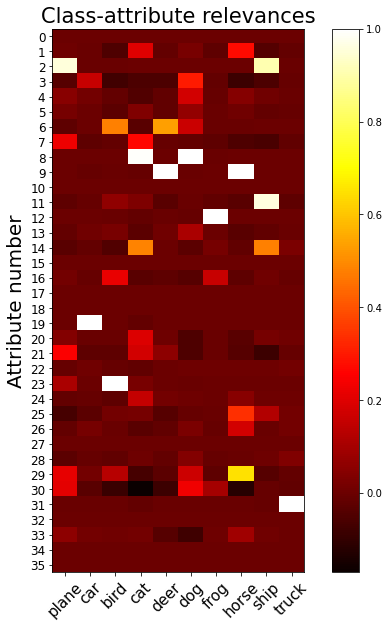

In [9]:
print ('Generating explanations')
global_rel = flint.generate_model_explanations(f, g, h, d, train_data, device, dataset, checkpoint1, model_name='sample_model', subset=True)
print(global_rel.shape)
flint.plot_rel(global_rel, 'cifar10', classes)

Predicted class: truck


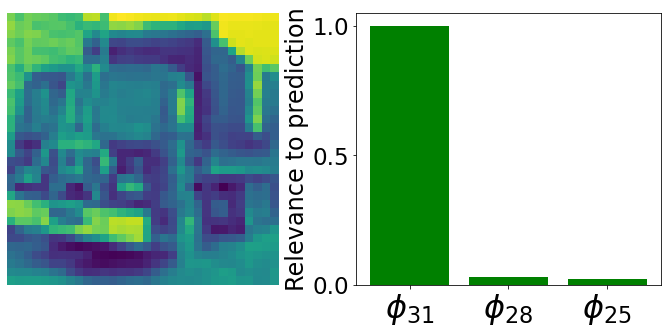

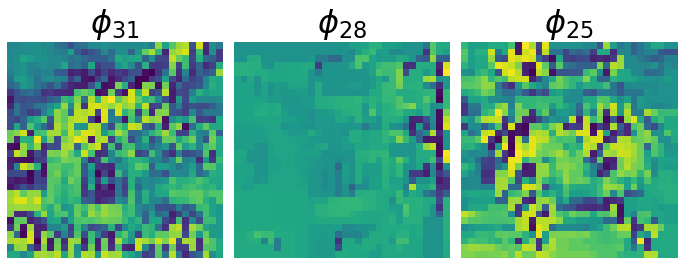

In [10]:
im1, im2 = flint.analyze_img(f, g, h, d, test_data, classes, device, 14, n_attr=3, save=False, location=None)

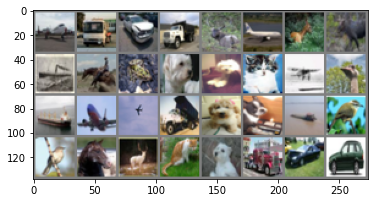

GroundTruth:  plane truck   car truck


In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
tweak.imshow(torchvision.utils.make_grid(images),norm_mean, norm_std)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
print(images[0].min(), images[0].max(), images[0].shape, images[0].type())

tensor(-0.8745) tensor(0.8745) torch.Size([3, 32, 32]) torch.FloatTensor


In [13]:
# Z = tweak.generate_tweak()
# Z_tensor = torch.Tensor(Z)
# Z_tensor_3dim = torch.unsqueeze(Z_tensor, 0)
# noise_tensor = torch.cat((Z_tensor_3dim,Z_tensor_3dim,Z_tensor_3dim),0)
# print(noise_tensor.min(), noise_tensor.max(), noise_tensor.shape, noise_tensor.type())
# print(images[0].min(), images[0].max(), images[0].shape, images[0].type())

# tweaked_img = images[0] - noise_tensor
# # print(tweaked_img.min(), tweaked_img.max(), tweaked_img.shape, tweaked_img.type())
# tweaked_img_double = tweaked_img.double()
# # print(tweaked_img_double.min(), tweaked_img_double.max(), tweaked_img_double.shape, tweaked_img_double.type())
# # transform2 = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(norm_mean, norm_std) ])

# tweaked = torch.where(tweaked_img_double < -1., -1., tweaked_img_double)
# print(tweaked.min(), tweaked.max(), tweaked.shape,tweaked.type())
# final_tweaked = tweaked.float()
# print(final_tweaked.min(), final_tweaked.max(), final_tweaked.shape,final_tweaked.type())
# # noise = transform2(final_noise)
# # print(noise.min(), noise.max(), noise.shape, noise.type())
# # noise3 = np.expand_dims(Z, axis=2)
# # new_noise = np.append(noise3, noise3, axis=2)
# # final_noise = np.append(new_noise,noise3, axis=2)
# # print(final_noise.shape)

# # tweaked_image = img - final_noise
# # print(tweaked_image.min(), tweaked_image.max(), tweaked_image.shape)
# tweak.imshow(final_tweaked,norm_mean, norm_std)

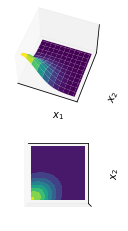

deformation maxi: 0.5696834598676144
sigX 0.3335232343475809
sigY 0.259100596981391
cov 0.09146608574423903


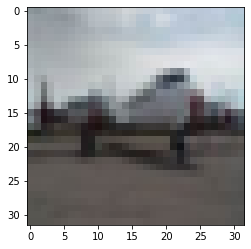

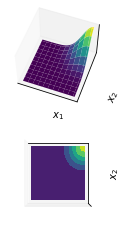

deformation maxi: 0.8023541382516229
sigX 0.17091817241361512
sigY 0.23220196749472688
cov 0.01846234191104277


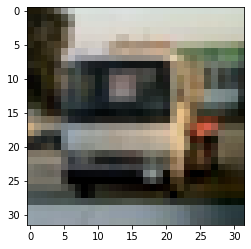

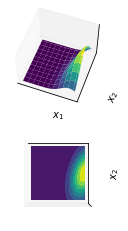

deformation maxi: 0.7889350620097192
sigX 0.1233283003450159
sigY 0.39061607411103794
cov 0.08721231878307287


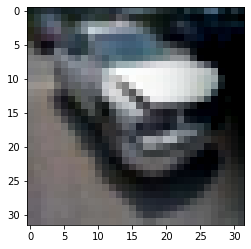

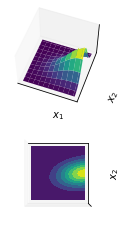

deformation maxi: 0.7507001413691443
sigX 0.4222261879755306
sigY 0.10975909373357094
cov 0.04286049602293035


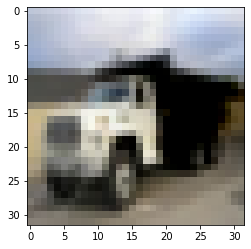

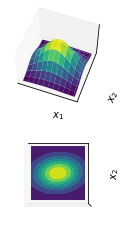

deformation maxi: 0.6868023370826336
sigX 0.33531431922118904
sigY 0.15972194477056978
cov 0.018327050231206756


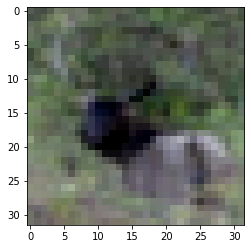

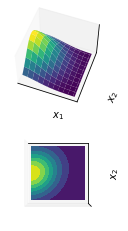

deformation maxi: 0.3880554010531895
sigX 0.47475932012774336
sigY 0.35917554923082673
cov 0.05297463274634622


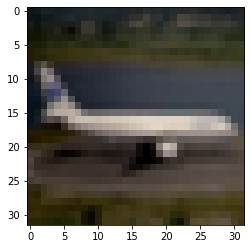

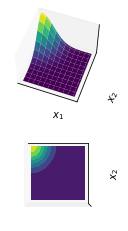

deformation maxi: 0.6472146435458209
sigX 0.22898065779271393
sigY 0.2650098324483031
cov 0.01454719966867788


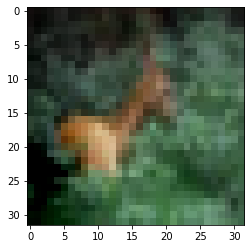

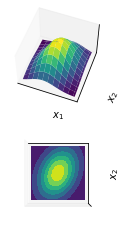

deformation maxi: 0.5319822991202882
sigX 0.24645917526590672
sigY 0.39460730732345395
cov 0.09071633637796538


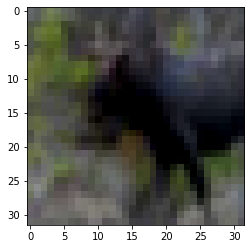

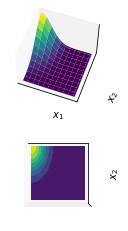

deformation maxi: 0.6086668200891439
sigX 0.15467255969834987
sigY 0.4420527005621776
cov 0.0009969753734948906


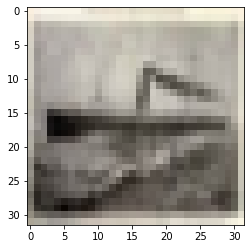

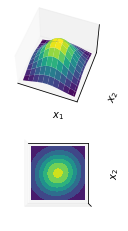

deformation maxi: 0.4983292105294394
sigX 0.32538332059179753
sigY 0.3130228464330718
cov 0.021718290443339918


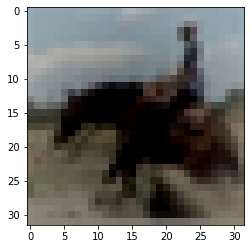

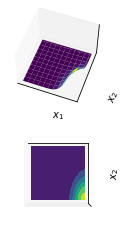

deformation maxi: 0.8175137988111721
sigX 0.10218406977118458
sigY 0.3847988365032259
cov 0.03767442867028478


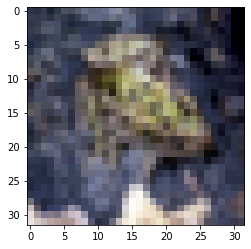

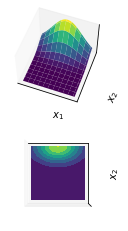

deformation maxi: 0.7006306011757408
sigX 0.3437167991729687
sigY 0.14967905224048084
cov 0.0013137319541003723


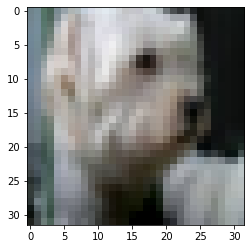

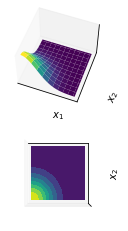

deformation maxi: 0.4631801986878999
sigX 0.3341518378416668
sigY 0.3533525174324874
cov 0.0017873062112046757


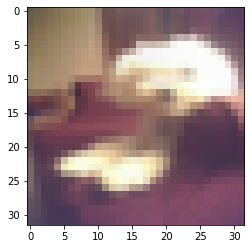

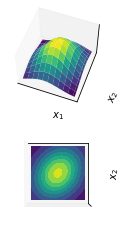

deformation maxi: 0.4116730022877956
sigX 0.37496980844811745
sigY 0.41667896237520674
cov 0.08616417224975259


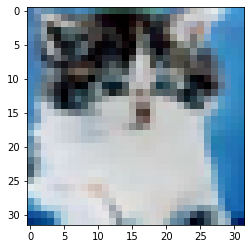

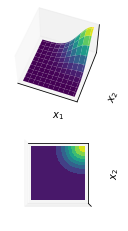

deformation maxi: 0.5977826650738155
sigX 0.2810100996460974
sigY 0.25461057521412456
cov 0.025753828580942453


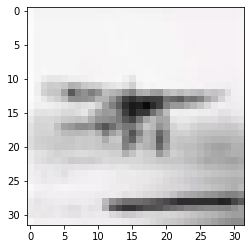

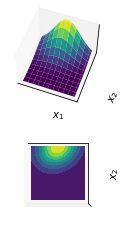

deformation maxi: 0.6305157871951904
sigX 0.26186577367248864
sigY 0.2517585020892153
cov 0.04973406327914409


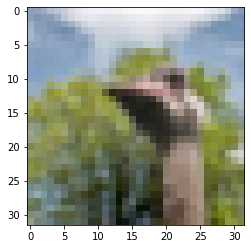

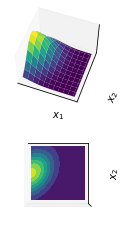

deformation maxi: 0.5843215701486173
sigX 0.2749138257665792
sigY 0.29889526241141007
cov 0.09093180461938391


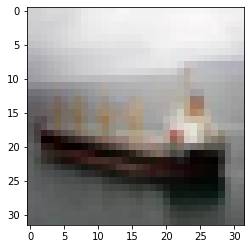

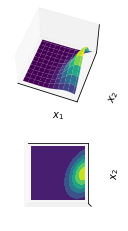

deformation maxi: 0.842561774217202
sigX 0.16036928192244515
sigY 0.25708756264346644
cov 0.07559920111216097


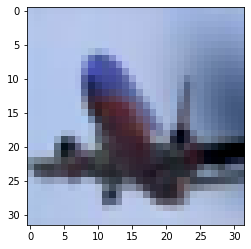

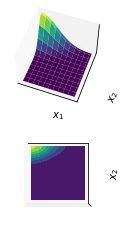

deformation maxi: 0.7233918239891901
sigX 0.4456485477308846
sigY 0.11881126783840107
cov 0.0673999380479337


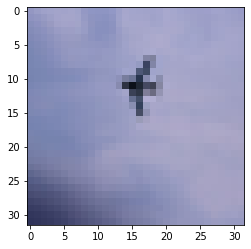

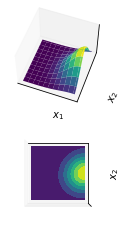

deformation maxi: 0.6765229754982635
sigX 0.24782719454811525
sigY 0.22357918581474567
cov 0.017969506728686992


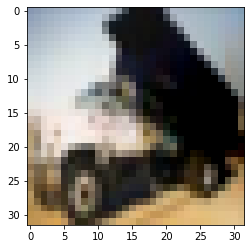

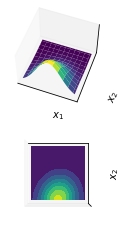

deformation maxi: 0.5820127438910087
sigX 0.22684103314942394
sigY 0.33154590929118505
cov 0.027852687408544154


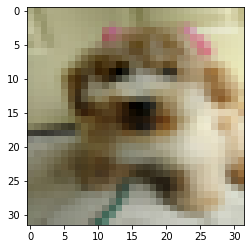

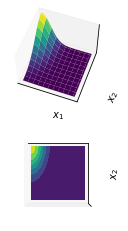

deformation maxi: 0.6453966791205462
sigX 0.12745274624505876
sigY 0.48236989600883384
cov 0.025840176204077893


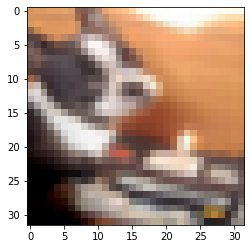

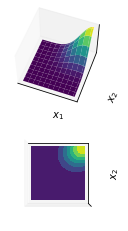

deformation maxi: 0.6949566003841054
sigX 0.2522335975020021
sigY 0.22875314286485532
cov 0.07246872187326127


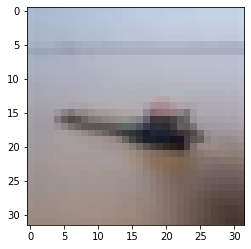

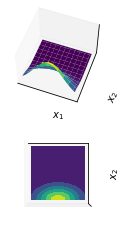

deformation maxi: 0.8303866430487374
sigX 0.3077344634178405
sigY 0.11898499745760871
cov 0.0022020839071522857


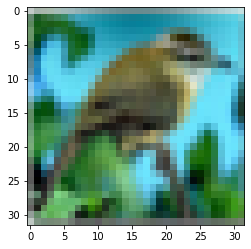

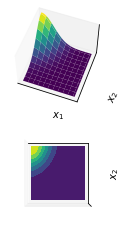

deformation maxi: 0.552309787660934
sigX 0.2481543307159147
sigY 0.3504209356332252
cov 0.06261687930781328


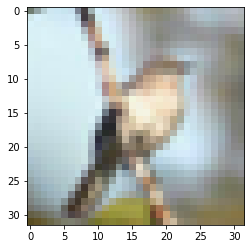

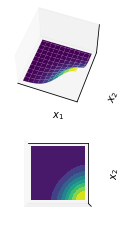

deformation maxi: 0.39864552017028126
sigX 0.39174410189696685
sigY 0.42025541874892314
cov 0.07239194447140743


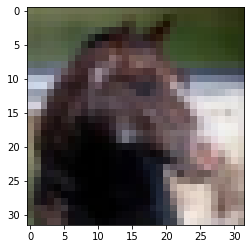

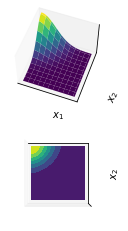

deformation maxi: 0.5551452699309938
sigX 0.32189375929393316
sigY 0.2630902523422789
cov 0.0499559531048687


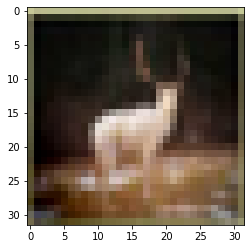

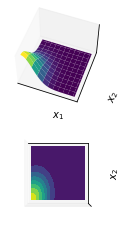

deformation maxi: 0.6007187336176716
sigX 0.1829431237311841
sigY 0.3990224732465685
cov 0.052959926547484694


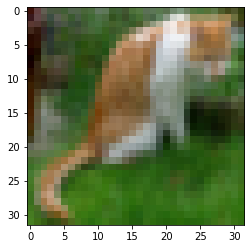

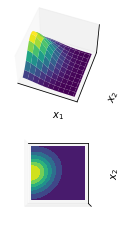

deformation maxi: 0.5535678033275455
sigX 0.3333213691645714
sigY 0.2504182493978492
cov 0.0340106119055536


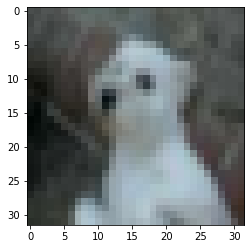

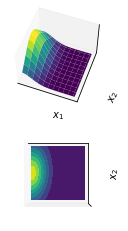

deformation maxi: 0.6035365044402269
sigX 0.15271636921194143
sigY 0.45620051274083684
cov 0.01698893118071132


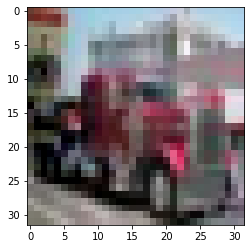

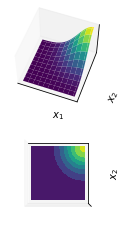

deformation maxi: 0.4389575602064235
sigX 0.3288792308819496
sigY 0.4005485197743165
cov 0.01648072422725474


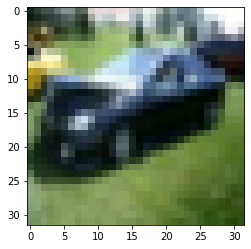

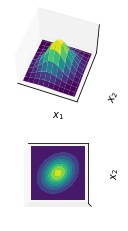

deformation maxi: 1.090191735995568
sigX 0.15381490504009282
sigY 0.14614801982526404
cov 0.03745310557583035


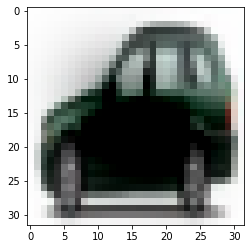

In [14]:
tweaked_list = []
for i in range(images.shape[0]):
    tweaked = tweak.apply_tweak(images[i],norm_mean,norm_std)
    tweaked_list.append(tweaked)

In [ ]:
vs=[0.1,0.5]
random.uniform(vs)

In [ ]:
plt.imshow(-Z)

In [ ]:
plt.imshow(my_img[:,:,0]-Z)

In [ ]:
new_img = my_img[:,:,0]-Z
print(new_img.min(),new_img.max())

In [ ]:
Z